In [129]:
import cv2 as cv
import numpy as np
from matplotlib.pylab import imshow

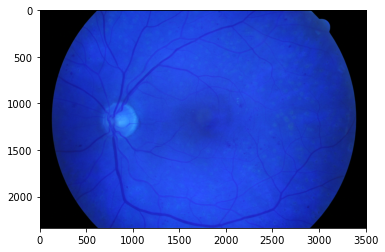

In [130]:
image = cv.imread('data/all/images/01_dr.JPG')
imshow(image, cmap='gray')

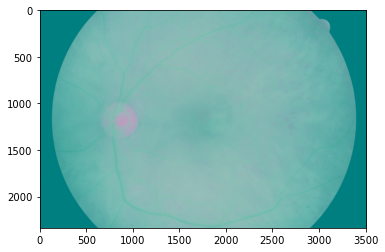

In [131]:
#convert to CIELAB color space and extract lightness
image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
l, a, b = cv.split(image_lab)

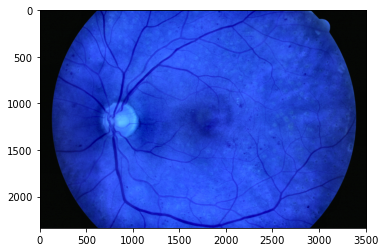

In [132]:
#apply contrast limited adaptive histogram equalization to the L channel
#https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv.createCLAHE(clipLimit=2.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2BGR)
#imshow(clahe.apply(l))
imshow(merged)

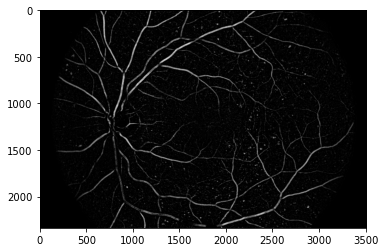

In [133]:
# convert image to BGR and extract green channel (vessels' visibility is the best)
b, g, r = cv.split(merged)

# 3 layers/times of alternate sequential filtering to remove noise from image
# MORPH_OPEN smoothes the edges
# MORPH_CLOSE removes (fills) all gaps between fragments of vessels
# cv.getStructuringElement(2, (5, 5)) - 2 stands for MORPH_ELLIPSE (ellpise inscribed into 5x5 rectangle)
# >>> cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
# array([[0, 0, 1, 0, 0],
#        [1, 1, 1, 1, 1],
#        [1, 1, 1, 1, 1],
#        [1, 1, 1, 1, 1],
#        [0, 0, 1, 0, 0]], dtype=uint8)


asf_1_open = cv.morphologyEx(g, cv.MORPH_OPEN, cv.getStructuringElement(
    2, (5, 5)), iterations=1)
asf_1_close = cv.morphologyEx(asf_1_open, cv.MORPH_CLOSE, cv.getStructuringElement(2, (5, 5)), iterations=1)

asf_2_open = cv.morphologyEx(asf_1_close, cv.MORPH_OPEN, cv.getStructuringElement(
    2, (11, 11)), iterations=1)
asf_2_close = cv.morphologyEx(asf_2_open, cv.MORPH_CLOSE, cv.getStructuringElement(2, (11, 11)), iterations=1)

asf_2_open = cv.morphologyEx(asf_2_close, cv.MORPH_OPEN, cv.getStructuringElement(
    2, (23, 23)), iterations=1)
asf_2_close = cv.morphologyEx(asf_2_open, cv.MORPH_CLOSE, cv.getStructuringElement(2, (23, 23)), iterations=1)

subtract_green = cv.subtract(asf_2_close, g)

# adjust histogram
asf_final = clahe.apply(subtract_green)

imshow(asf_final, cmap='gray')


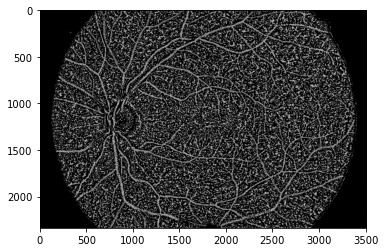

In [134]:
# white top-hat transform (f-f*b)
f = asf_final
b = cv.morphologyEx(f, cv.MORPH_CLOSE, cv.getStructuringElement(
    2, (5, 5)))
top_hat = f - b
imshow(top_hat, cmap='gray')


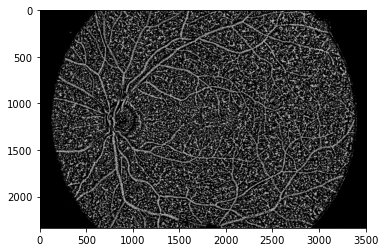

In [135]:
image_g = cv.GaussianBlur(top_hat, (5, 5), 0)
imshow(image_g, cmap='gray')

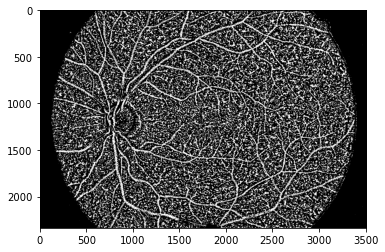

In [136]:
ret, thresh = cv.threshold(image_g, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
imshow(thresh, cmap='gray')

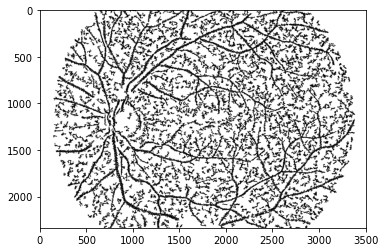

In [137]:
_, thresh2 = cv.threshold(thresh, 15, 255, cv.THRESH_BINARY)
#create black mask of the processed image size
black_mask = np.ones(thresh.shape[:2], dtype=type(thresh[0][0])) * 255
contours, _ = cv.findContours(
    thresh2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if cv.contourArea(cnt) <= 250:
        #remove small countours
        cv.drawContours(black_mask, [cnt], -1, 0, -1)

image_masked = cv.bitwise_and(thresh, thresh, mask=black_mask)
#the smaller the ellipse the longer it takes to remove blobs in the next step (more blobs)
_, image_masked = cv.threshold(image_masked, 15, 255, cv.THRESH_BINARY_INV)
image_eroded = cv.erode(image_masked, cv.getStructuringElement(
    cv.MORPH_ELLIPSE, (3, 3)), iterations=1)

imshow(image_eroded, cmap='gray')

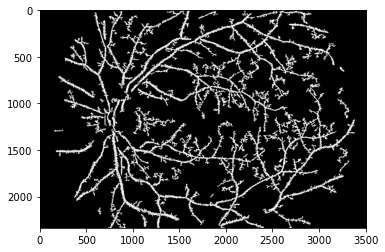

In [138]:
image_eroded = cv.bitwise_not(image_eroded)
#create black mask of the processed image size
mask = np.ones(image_eroded.shape[:2], dtype=type(thresh[0][0])) * 255
contours, _ = cv.findContours(
    image_eroded, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    #perimeter
    cnt_perimeter = 0.04 * cv.arcLength(cnt, True)
    approx = cv.approxPolyDP(cnt, cnt_perimeter, False)
    #blob 'detection'
    if len(approx) > 4 and cv.contourArea(cnt) >= 100 and cv.contourArea(cnt) <= 3500:
        cv.drawContours(mask, [cnt], -1, 0, -1)

image_masked_2 = cv.bitwise_and(image_eroded, image_eroded, mask=mask)
blood_vessels = cv.subtract(255, cv.bitwise_not(image_masked_2))

imshow(blood_vessels, cmap='gray')

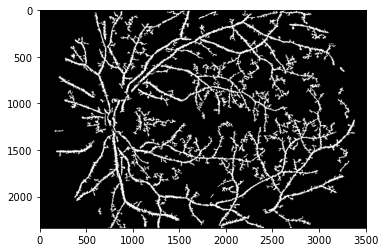

In [139]:
#post processing 
asf_1 = cv.morphologyEx(blood_vessels, cv.MORPH_OPEN, cv.getStructuringElement(0, (4, 4)))
asf_1_final = cv.morphologyEx(asf_1, cv.MORPH_CLOSE, cv.getStructuringElement(0, (4, 4)))
imshow(asf_1_final, cmap='gray')

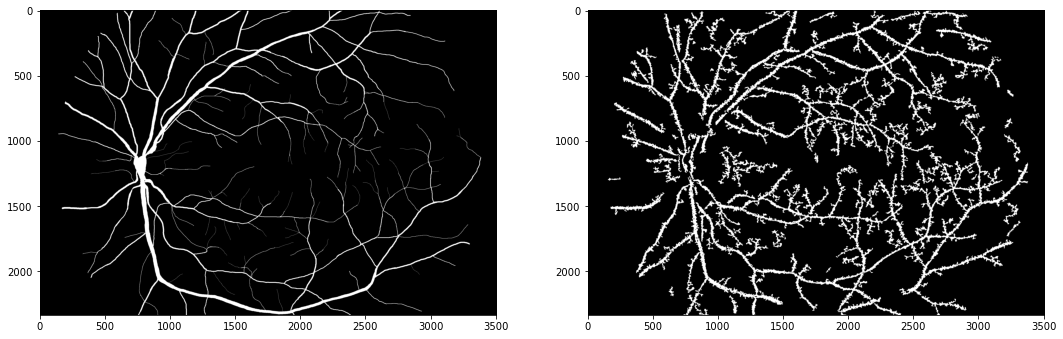

In [140]:
from matplotlib import pyplot as plt
#load the hand-made mask
mask = cv.imread('data/all/manual1/01_dr.tif', cv.IMREAD_GRAYSCALE)
#imshow(mask, cmap='gray')
diff = (asf_1_final - mask)
#imshow(diff, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(mask, cmap='gray')
ax2.imshow(asf_1_final, cmap='gray')


In [141]:
processed = asf_1_final
TP, TN, FP, FN = 0, 0, 0, 0
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i][j] >= 127 and processed[i][j] >= 127:
            TP += 1
        elif mask[i][j] < 127 and processed[i][j] >= 127:
            FP += 1
        elif mask[i][j] >= 127 and processed[i][j] < 127:
            FN += 1
        elif mask[i][j] < 127 and processed[i][j] < 127:
            TN += 1


In [142]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensivity = TP / (TP + FN)
specifity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)

accuracy: 0.8934025252939889
sensivity:  0.7044983929163403
specifity:  0.9035243894307962
